In [91]:
import torch
from torch import utils
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data import WeightedRandomSampler, DataLoader

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tabulate import tabulate

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [97]:
#Formating for matplotlib to view confusion matrix in the end 
import matplotlib
font = {'weight' : 'bold',
        'family' : 'sans-serif',
        'size'   : 6}

matplotlib.rc('font', **font)

In [2]:
#GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", device)
torch.cuda.empty_cache()

Running on cuda


In [3]:
#Data Located in Parent Folder 
os.chdir('..')
path = os.getcwd() + '/AugmentedData/'
classes = os.listdir(path)
classes.sort()

In [4]:
#Create the tensor transforms
transform_general = transforms.Compose(
    [transforms.ToTensor()])

#Load Dataset
print(path)
data = datasets.ImageFolder(path, transform=transform_general)

# Split into train/val/test sets:
#80% of the full dataset is used for training
train_len = int(len(data)*0.8)
trainData, remaining = random_split(data, [train_len, len(data) - train_len])
#80% of the remaining dataset
val_len = int(len(remaining)*0.8)
valData, testData = random_split(remaining, [val_len, len(remaining) - val_len])

print("Train set : ", len(trainData))
print("Val set : ", len(valData))
print("Test set : ", len(testData))

c:\Users\Divya\Desktop\Kvasir-Capsule-ML-Project/AugmentedData/
Train set :  18186
Val set :  3637
Test set :  910


In [5]:
#Calculating Class weights 

# Extract classes:
train_classes = [trainData.dataset.targets[i] for i in trainData.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values])
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[trainData.dataset.targets[i]] for i in trainData.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(trainData)*2), replacement=True)

In [6]:
# Torch dataloaders:
batch_size = 32
dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train = DataLoader(trainData, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train)*batch_size)

val = DataLoader(valData, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a validation set is:", len(val)*batch_size)

test = DataLoader(testData, batch_size=batch_size, shuffle=True, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(test)*batch_size)
print(dataloaders.dataset)

The total number of images is: 1137
The number of images in a training set is: 36384
The number of images in a validation set is: 3648
The number of images in a test set is: 928
Dataset ImageFolder
    Number of datapoints: 22733
    Root location: c:\Users\Divya\Desktop\Kvasir-Capsule-ML-Project/AugmentedData/
    StandardTransform
Transform: Compose(
               ToTensor()
           )


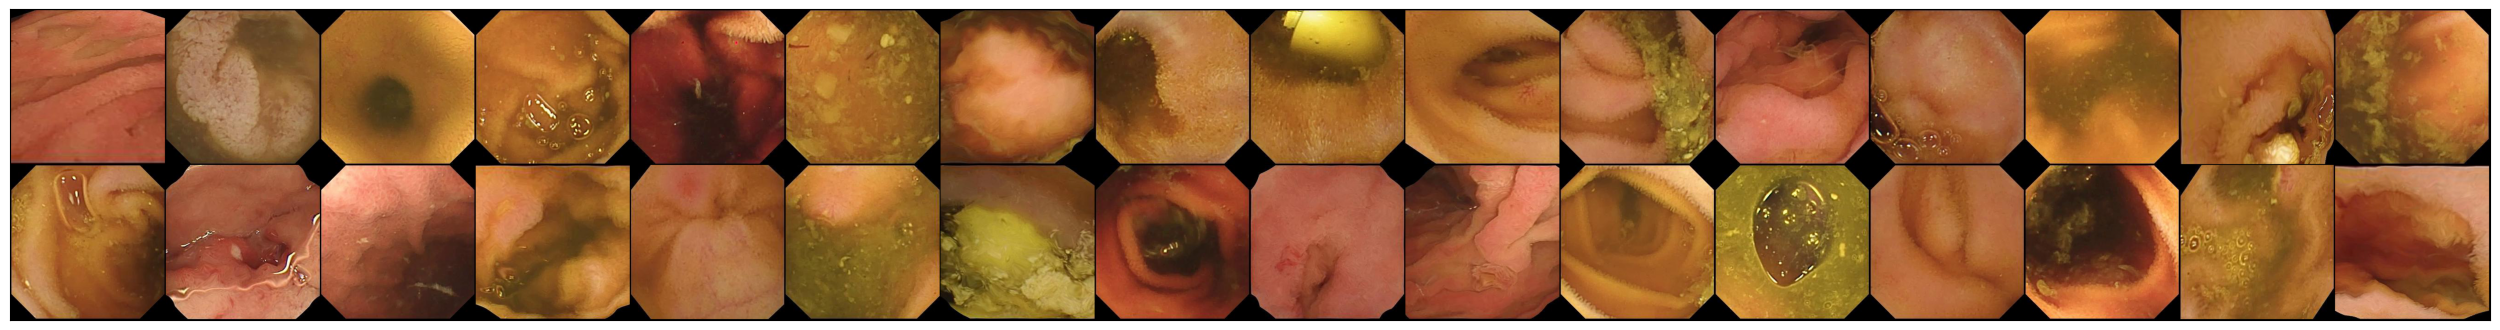

In [7]:
def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (32,32))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

show_batch(train)

In [8]:
#Creating a simple CNN architechture
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()

    #Defining a sequential model layers
    self.c1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=5, padding=0, stride=1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.c2 = nn.Sequential(
        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=3, padding=0, stride=1),
        nn.LeakyReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.c3 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=3, padding=1, stride=2),
        nn.LeakyReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )
    self.drop = nn.Dropout()
    self.fc = nn.Linear(in_features = 25600, out_features = 14)

  def forward(self, x):
    output = self.c1(x)
    output = self.c2(output)
    output = self.drop(output)
    output = self.c3(output)
    #or nn.Flatten()
    output = output.reshape(output.size(0), -1)
    # Each img : (336 x 336)
    # Formula : w' = ((W - F + 2P)/S) + 1
    output = self.fc(output)
    return output


In [9]:
#Define model
model = SimpleCNN().to(device)
print(model)

from torchsummary import summary
summary(model, (3, 336, 336))

SimpleCNN(
  (c1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (c2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (c3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (drop): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=25600, out_features=14, bias=True)
)
Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 166, 166]        --
|    └─Conv2d: 2-1                       [-1, 16, 332, 332]        1,216
|    └─LeakyReLU: 2-2                    [-1, 16, 332, 332] 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 166, 166]        --
|    └─Conv2d: 2-1                       [-1, 16, 332, 332]        1,216
|    └─LeakyReLU: 2-2                    [-1, 16, 332, 332]        --
|    └─MaxPool2d: 2-3                    [-1, 16, 166, 166]        --
├─Sequential: 1-2                        [-1, 32, 82, 82]          --
|    └─Conv2d: 2-4                       [-1, 32, 164, 164]        4,640
|    └─LeakyReLU: 2-5                    [-1, 32, 164, 164]        --
|    └─MaxPool2d: 2-6                    [-1, 32, 82, 82]          --
├─Dropout: 1-3                           [-1, 32, 82, 82]          --
├─Sequential: 1-4                        [-1, 64, 20, 20]          --
|    └─Conv2d: 2-7                       [-1, 64, 41, 41]          18,496
|    └─LeakyReLU: 2-8                    [-1, 64, 41, 41]          --
|    └─AvgPool2d: 2-9                    [-1, 64, 20, 20]          --
├─Lin

In [10]:
lossCriteria = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
#Visulaize the Results
def plot_acc_curve(train_accuracy, validation_accuracy):

  plt.plot(train_accuracy, color='green')
  #plt.plot(validation_accuracy, color='blue')
  plt.xlabel('epoch')
  plt.ylabel('Accuracy')
  plt.title('Training Accuracy')

  plt.show()

def plot_loss_curve(train_losses, validation_losses):
  plt.plot(train_losses, color='green')
  #plt.plot(validation_losses, color='blue')
  plt.xlabel('epoch')
  plt.ylabel('Loss')
  plt.title('Training Losses')

  plt.show()

In [12]:
def train_validate_test_model(e, train, test, val, model, optimizer):

  train_losses = []
  train_accuracy_list = []

  test_losses = []
  test_accuracy_list = []

  val_losses = []
  val_accuracy_list = []

  # Initialize the prediction and label lists(tensors)
  predlist=torch.zeros(0,dtype=torch.long, device='cpu')
  lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

  predlist__ =torch.zeros(0,dtype=torch.long, device='cpu')
  lbllist__ =torch.zeros(0,dtype=torch.long, device='cpu')

  for epoch in range(e):

    run_loss = 0.0
    val_loss = 0.0
    t_loss = 0.0

    #TRAINING

    model.train()
    correct = 0
    total = 0

    for img, class_ in train:

          img, class_ = img.to(device), class_.to(device)

          optimizer.zero_grad()
          preds = model(img)

          loss = lossCriteria(preds, class_)

          loss.backward()
          optimizer.step()

          run_loss += loss.item()

          _, predicted = preds.max(1)
          total += class_.size(0)
          correct += predicted.eq(class_).sum().item()


    accuracy_train = correct * 100. / total
    train_accuracy_list.append(accuracy_train)


    train_loss = run_loss / len(train.sampler)
    train_losses.append(train_loss)

    #validate
    with torch.no_grad():
      model.eval()
      correct_ = 0
      total_ = 0

      for img, class_ in val:

          img, class_ = img.to(device), class_.to(device)

          preds_ = model(img)
          loss = lossCriteria(preds_, class_)
          val_loss += loss.item()

          _, predicted = preds_.max(1)
          total_ += class_.size(0)
          correct_ += predicted.eq(class_).sum().item()

          #Append batch prediction results
          predlist = torch.cat([predlist, predicted.view(-1).cpu()])
          lbllist = torch.cat([lbllist, class_.view(-1).cpu()])


    accuracy_val = correct_ * 100. / total_
    val_accuracy_list.append(accuracy_val)


    val_loss = val_loss / len(test.sampler)
    val_losses.append(val_loss)


    print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f}'.format(epoch, train_loss, accuracy_train, val_loss, accuracy_val))

  #test
  with torch.no_grad():
    model.eval()
    correct_ = 0
    total_ = 0

    for img, class_ in test:

        img, class_ = img.to(device), class_.to(device)

        preds_ = model(img)
        loss = lossCriteria(preds_, class_)
        t_loss += loss.item()

        _, predicted = preds_.max(1)
        total_ += class_.size(0)
        correct_ += predicted.eq(class_).sum().item()

        #Append batch prediction results
        predlist__ = torch.cat([predlist__, predicted.view(-1).cpu()])
        lbllist__ = torch.cat([lbllist__, class_.view(-1).cpu()])

    accuracy_test = correct_ * 100. / total_
    test_accuracy_list.append(accuracy_test)


    t_loss = t_loss / len(test.sampler)
    test_losses.append(t_loss)

  #Confusion matrix
  conf_mat_val = confusion_matrix(lbllist.numpy(), predlist.numpy())
  print("The Val conf mat ", conf_mat_val)

  #Confusion matrix
  conf_mat_test = confusion_matrix(lbllist.numpy(), predlist.numpy())
  print("The Test conf mat ", conf_mat_test)


  return train_losses, train_accuracy_list, test_losses, test_accuracy_list, val_losses, val_accuracy_list, conf_mat_val, conf_mat_test


In [13]:
train_losses, train_accuracy, test_losses, test_accuracy, val_losses, val_accuracy, conf_matrix_val, conf_matrix_test = train_validate_test_model(20, train, test, val, model, optimizer)

Epoch: 0 	Training Loss: 0.0266 	Training Accuracy: 71.9702 	Validation Loss: 0.0832 	Validation Accuracy: 77.6189
Epoch: 1 	Training Loss: 0.0096 	Training Accuracy: 89.8796 	Validation Loss: 0.0575 	Validation Accuracy: 86.6648
Epoch: 2 	Training Loss: 0.0064 	Training Accuracy: 93.2805 	Validation Loss: 0.0531 	Validation Accuracy: 86.6648
Epoch: 3 	Training Loss: 0.0044 	Training Accuracy: 95.4196 	Validation Loss: 0.0618 	Validation Accuracy: 87.0223
Epoch: 4 	Training Loss: 0.0035 	Training Accuracy: 96.3323 	Validation Loss: 0.0668 	Validation Accuracy: 86.8573
Epoch: 5 	Training Loss: 0.0028 	Training Accuracy: 96.9537 	Validation Loss: 0.0564 	Validation Accuracy: 89.3594
Epoch: 6 	Training Loss: 0.0027 	Training Accuracy: 97.1874 	Validation Loss: 0.0641 	Validation Accuracy: 87.9846
Epoch: 7 	Training Loss: 0.0021 	Training Accuracy: 97.8637 	Validation Loss: 0.0630 	Validation Accuracy: 89.3044
Epoch: 8 	Training Loss: 0.0019 	Training Accuracy: 97.9380 	Validation Loss: 0.

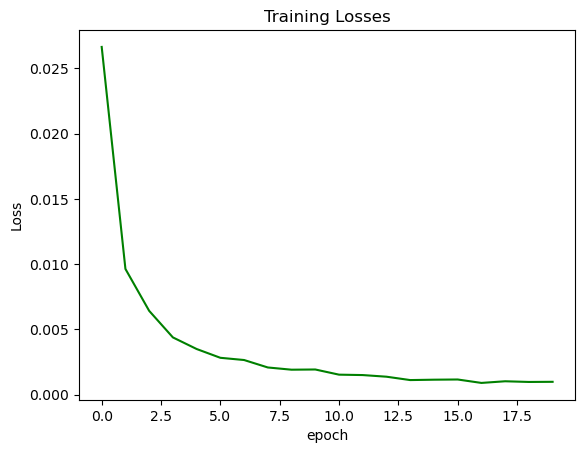

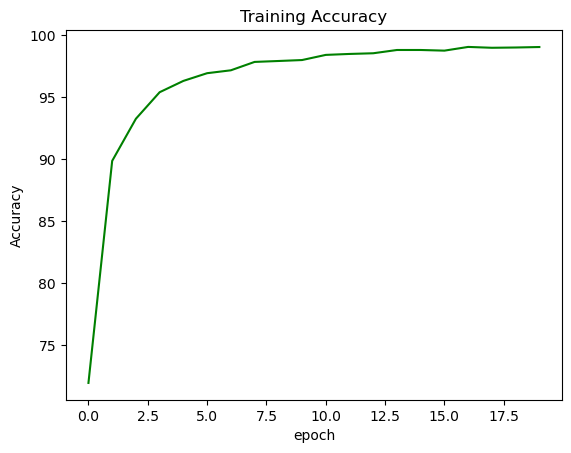

In [14]:
#Visualize Epoch training
plot_loss_curve(train_losses, val_losses)
plot_acc_curve(train_accuracy, val_accuracy)

In [15]:
classes = os.listdir(path)
classes.sort()

In [16]:
#Evaluation
#Function to calculate the F1 score
def get_f1_score(conf_matrix, i):
    TP, FP, TN, FN = 0, 0, 0, 0

    for j in range(len(conf_matrix)):
        if (i == j):
            TP += conf_matrix[i, j]
            tmp = np.delete(conf_matrix, i, 0)
            tmp = np.delete(tmp, j, 1)

            TN += np.sum(tmp)
        else:
            if (conf_matrix[i, j] != 0):

                FN += conf_matrix[i, j]
            if (conf_matrix[j, i] != 0):

                FP += conf_matrix[j, i]

    recall = TP / (FN + TP)
    precision = TP / (TP + FP)
    f1_score = 2 * 1/(1/recall + 1/precision)

    return f1_score

#function to retrieve class accuracies for each class
def per_class_accuracies(conf_mat):
  class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
  print("Per class accuracy : ", class_accuracy)
  return class_accuracy

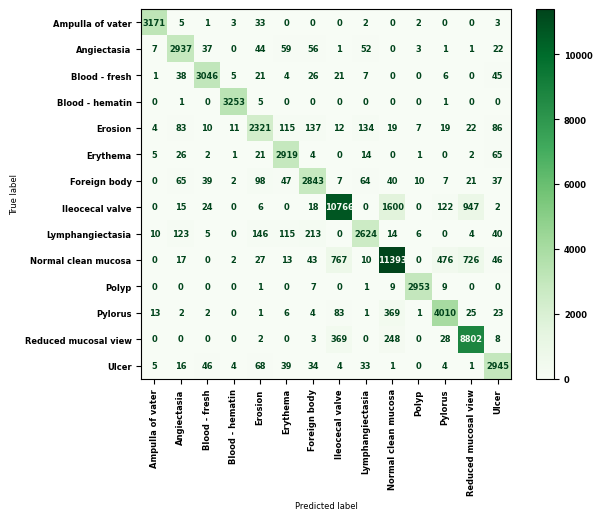

In [99]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test, display_labels=classes)
disp.plot(cmap='Greens', xticks_rotation="vertical", )

In [101]:
class_accuracies = per_class_accuracies(conf_matrix_val)

f1Scores = []
for i in range(len(classes)-1):
    f1Scores.append(get_f1_score(conf_matrix_test, i))
print("The f1 scores for Induvidual classes are : ", f1Scores)

Per class accuracy :  [98.47826087 91.21118012 94.59627329 99.78527607 77.88590604 95.39215686
 86.67682927 79.74814815 79.51515152 84.26775148 99.09395973 88.32599119
 93.04439746 92.03125   ]
The f1 scores for Induvidual classes are :  [0.9853946550652578, 0.8970678069639585, 0.9471393034825869, 0.9946491362177038, 0.8039487357118116, 0.915477497255763, 0.8527294541091783, 0.8433999216607913, 0.8407561678949055, 0.8373203983390292, 0.9904410531611604, 0.8695652173913044, 0.8797161561141373]


In [102]:
headers = ['Class', 'Accuracy', 'F1 Score']
print(tabulate(zip(classes, class_accuracies, f1Scores), headers=headers, floatfmt=".4f"))

Class                   Accuracy    F1 Score
--------------------  ----------  ----------
Ampulla of vater         98.4783      0.9854
Angiectasia              91.2112      0.8971
Blood - fresh            94.5963      0.9471
Blood - hematin          99.7853      0.9946
Erosion                  77.8859      0.8039
Erythema                 95.3922      0.9155
Foreign body             86.6768      0.8527
Ileocecal valve          79.7481      0.8434
Lymphangiectasia         79.5152      0.8408
Normal clean mucosa      84.2678      0.8373
Polyp                    99.0940      0.9904
Pylorus                  88.3260      0.8696
Reduced mucosal view     93.0444      0.8797


In [42]:
#saving the model for future training purposes 
#torch.save(model, 'model.pth')